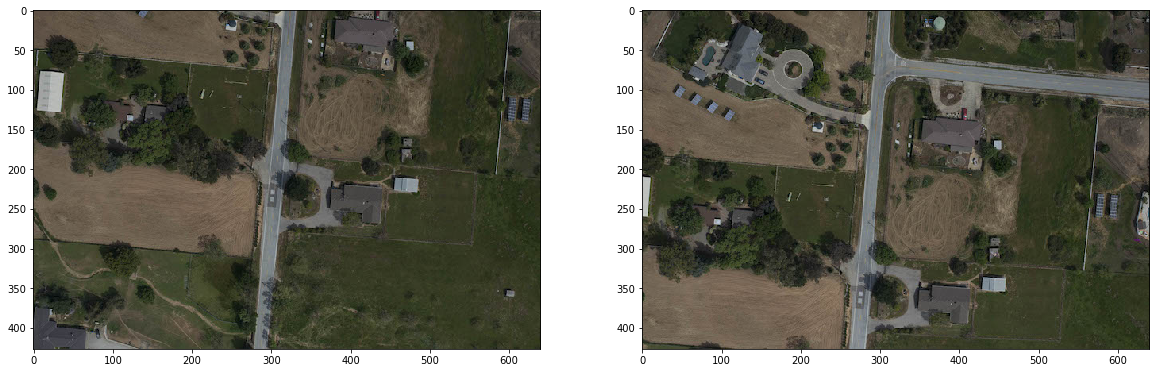

In [75]:
%matplotlib inline
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

SRC_IMG = "data/a.jpg"
DET_IMG = "data/b.jpg"

im1 = cv2.imread(SRC_IMG)
im2 = cv2.imread(DET_IMG)

def plot_im(img, points=None):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
plt.figure(figsize=(20,20))       
plt.subplot(121)
plot_im(im1)
plt.subplot(122)
plot_im(im2)

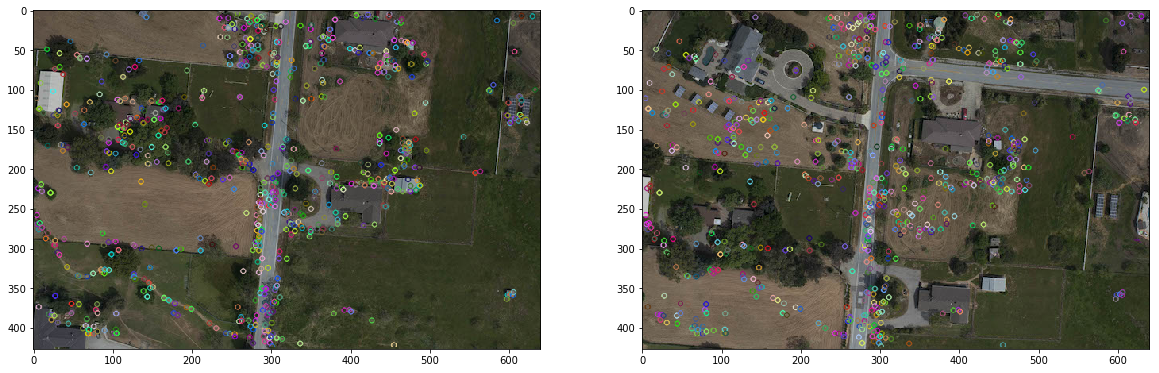

In [76]:
def detect_and_describe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)

    # return a tuple of keypoints and features
    return (kps, features)

(kps1, features1) = detect_and_describe(im1)
(kps2, features2) = detect_and_describe(im2)

vis1 = cv2.drawKeypoints(im1, kps1, outImage=np.array([]))
vis2 = cv2.drawKeypoints(im2, kps1, outImage=np.array([]))

plt.figure(figsize=(20,20))       
plt.subplot(121)
plot_im(vis1)
plt.subplot(122)
plot_im(vis2)

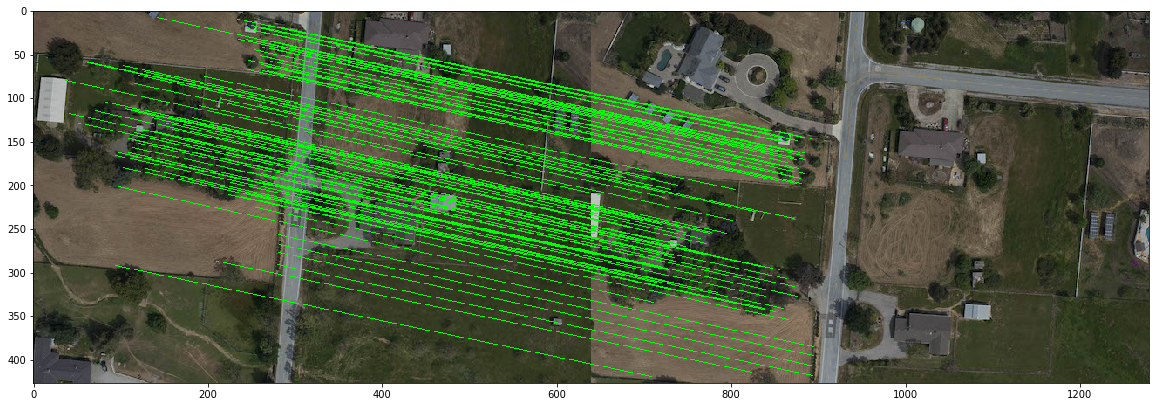

In [77]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB):
    ratio = 0.8
    min_matches = 100
    reprojThresh = 5.0
    
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    matches = matcher.knnMatch(featuresA, featuresB, 2)
    verified_matches = []

    # loop over the raw matches
    for m in matches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            verified_matches.append((m[0].trainIdx, m[0].queryIdx))
        
        # computing a homography requires at least 4 matches
        if len(verified_matches) > min_matches:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i].pt for (_, i) in verified_matches])
            ptsB = np.float32([kpsB[i].pt for (i, _) in verified_matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # return the matches along with the homograpy matrix and status of each matched point
            return (verified_matches, H, status)

    # otherwise, no homograpy could be computed
    return None

def draw_matches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx].pt[0]), int(kpsA[queryIdx].pt[1]))
            ptB = (int(kpsB[trainIdx].pt[0]) + wA, int(kpsB[trainIdx].pt[1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # return the visualization
    return vis


# Use SIFT to find keypoints and return homography matrix
matches, H, status = matchKeypoints(kps1, kps2, features1, features2)

vis = draw_matches(im1, im2, kps1, kps2, matches, status)
plt.figure(figsize=(20,20))       
plt.subplot(111)
plot_im(vis)

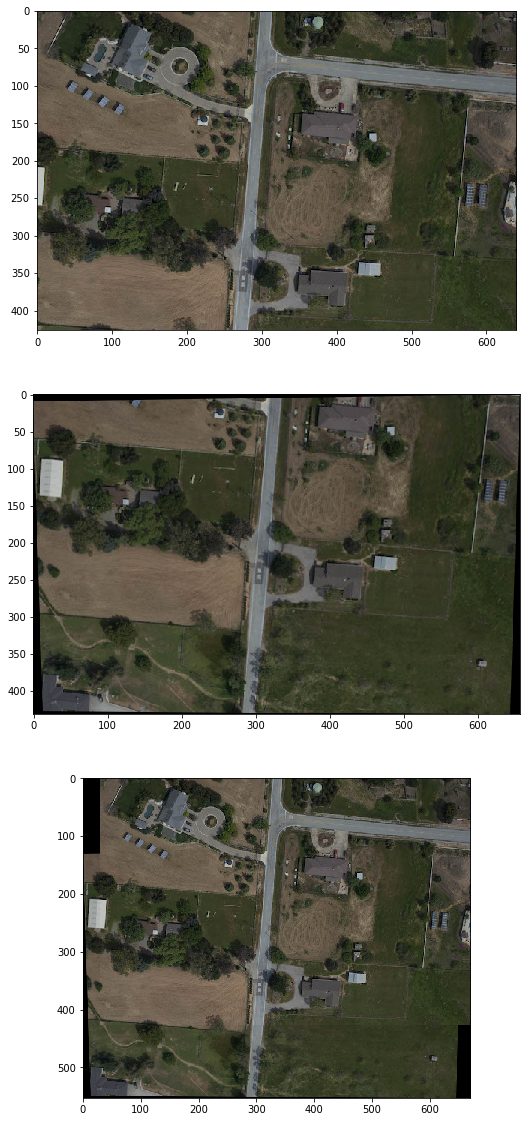

In [78]:
def stitch_images(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H),
                                     (x_max - x_min, y_max - y_min))
    output_img[translation_dist[1]:rows1 + translation_dist[1],
               translation_dist[0]:cols1 + translation_dist[0]] = img1
    return output_img


def warp_image(img, H):

    rows, cols = img.shape[:2]

    list_of_points_1 = np.float32([[0, 0], [0, rows], [cols, rows], [cols, 0]]).reshape(-1, 1, 2)
    list_of_points = cv2.perspectiveTransform(list_of_points_1, H)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    # print("x_min: " + str(x_min) + " y_min:" + str(y_min))
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]], [0, 0, 1]])
    output_img = cv2.warpPerspective(img, H_translation.dot(H),
                                     (x_max - x_min, y_max - y_min))
    return output_img

stitched_image = stitch_images(im2, im1, H)
warped_image = warp_image(im1, H)

plt.figure(figsize=(20,20))       
plt.subplot(311)
plot_im(im2)
plt.subplot(312)
plot_im(warped_image)
plt.subplot(313)
plot_im(stitched_image)